# Comparing HSIC versus Mutual Information measures

In this notebook, we will be exploring how we can estimate the HSIC parmaeter for different distributions and look at how it compares to MI measures. Normally the procedure for calculating HSIC is as follows:

1. Calculate kernel matrices for X and Y
2. Center both kernel matrices
3. Find the Frobenius norm between the kernel matrices

This works well but there is no certain way to estimate the parameter for each of the kernel matrices. There is another paper that is called the Kernel Tangent Alignment (KTA). This method is different as it is calculated like so:

1. Calculate the kernel matrices for X and Y
2. Find the Frobenius norm between the kernel matrices
3. Normalize the value by the Frobenius norm of X and Y individually

This works in a similar way to the HSIC method. The difference is that you do the normalization procedure. The final algorithm is the Centered Kernel Tangent Alignment (cKTA) method which is a combination of the previous two methods. The algorithm is as follows:

1. Calculate the kernel matrices for X and Y
2. Center both kernel matrices
3. Find the Frobenius norm between the kernel matrices
4. Normalize the value by the Frobenius norm of X and Y individually 

As you can see, it would appear that this method is the most complete in the sense that it incorporates all steps to ensure that our data is sufficiently scaled to a way that is directly comparable. This notebook will attempt to see which of these methods provides a good estimate for a sigma value for the kernel matrices and how do their output values compare to mutual information measures.

## Code

In [1]:
import sys, os
import warnings
import tqdm
import random
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

# Insert path to model directory,.
cwd = os.getcwd()
path = f"{cwd}/../../src"
sys.path.insert(0, path)

# Insert path to package,.
pysim_path = f"/home/emmanuel/code/pysim/"
sys.path.insert(0, pysim_path)

# toy datasets
from data.toy import generate_dependence_data
from dataclasses import dataclass

# Kernel Dependency measure
from pysim.kernel.hsic import HSIC
from pysim.kernel.utils import get_init_gammas, get_gamma_grid

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn-talk'])
%matplotlib inline

warnings.filterwarnings('ignore') # get rid of annoying warnings

%load_ext autoreload
%autoreload 2

## Example

### Data

In [2]:
def generate_data(data_params):
    
    # generate dataset
    X, Y = generate_dependence_data(
        dataset=data_params.dataset,
        num_points=data_params.n_points,
        seed=data_params.seed,
        noise_x=data_params.noise_x,
        noise_y=data_params.noise_y,
        alpha=data_params.alpha,
        beta=data_params.beta,
        norm_x=data_params.norm_x,
        norm_y=data_params.norm_y
    )
    
    return X, Y

def plot_toy_data(X, Y):
    
    fig, ax = plt.subplots(nrows=1, figsize=(7, 5))
    
    ax.scatter(X, Y)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    return fig, ax

In [3]:
# data params

@dataclass
class DataParams:
    dataset  = 'sine'
    n_points = 1_000
    seed     = 123
    noise_x  = 0.1
    noise_y  = 0.1
    alpha    = 1.0
    beta     = 1.0
    norm_x   = False
    norm_y   = False


X, Y = generate_data(DataParams)
print(X.min(), X.max())

8.188761366767494e-05 0.9989184059727976


#### Plot Toy Data

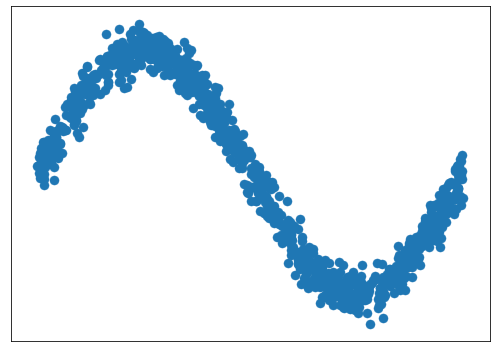

In [4]:
fig, ax = plot_toy_data(X, Y)


# save figures
plt.tight_layout()
save_path = f'{cwd}/../../results/figures/datasets/'
fig.savefig(f"{save_path}demo_{DataParams.dataset}.png")
plt.show()

## HSIC Score

In [5]:
def get_hsic_score(model_params, X, Y, method: str) -> float:
    
    if method == 'hsic':
        model_params.normalize = False     # HSIC
        model_params.center = True       
    elif method == 'ka':
        # change params for Kernel Alignment
        model_params.normalize = True
        model_params.center = False    
    elif method == 'cka':
        # change params for centered Kernel Alignment
        model_params.normalize = True
        model_params.center = True
    else:
        raise ValueError(f"Unrecognized hsic method: {method}")
        
    # initialize HSIC model
    clf_hsic = HSIC(
        kernel=ModelParams.kernel, 
        center=ModelParams.center,
        subsample=ModelParams.subsample,
        bias=ModelParams.bias,
        gamma_X=ModelParams.gamma_X,
        gamma_Y=ModelParams.gamma_Y
    )

    # calculate HSIC return scorer
    clf_hsic.fit(X, Y);

    # return score
    return clf_hsic.score(X, normalize=ModelParams.normalize)

#### HSIC

In [6]:
# Initialize dataclass parameters
@dataclass
class ModelParams:
    kernel = 'rbf'
    bias = True
    gamma_X = None
    gamma_Y = None
    subsample = None

In [7]:
init_gamma_X, init_gamma_Y = get_init_gammas(X, Y, method='median')
print(init_gamma_X, init_gamma_Y)

ModelParams.gamma_x = init_gamma_X
ModelParams.gamma_y = init_gamma_Y

# calculate hsic score
hsic_val = get_hsic_score(ModelParams, X, Y, 'hsic')
print(f"HSIC: {hsic_val:.5f}")

5.98564438705438 0.9496243328834307
HSIC: 0.05824


#### Kernel Tangent Alignment

In [8]:
init_gamma_X, init_gamma_Y = get_init_gammas(X, Y, method='median')

ModelParams.gamma_x = init_gamma_X
ModelParams.gamma_y = init_gamma_Y

# calculate kernel alignment score
ka_val = get_hsic_score(ModelParams, X, Y, 'ka')

print(f"KA: {ka_val:.5f}")

KA: 0.68847


#### Centered Kernel Tangent Alignment

In [9]:
init_gamma_X, init_gamma_Y = get_init_gammas(X, Y, method='median')

ModelParams.gamma_x = init_gamma_X
ModelParams.gamma_y = init_gamma_Y

# calculate centered kernel alignment score
cka_val = get_hsic_score(ModelParams, X, Y, 'cka')

print(f"CKA: {cka_val:.5f}")

CKA: 0.58843


## Problem I - Initial Values

So here I will demonstrate one of the problems with trying to use HSIC without proper consideration of the parameters. For this first problem, we will look at how the initialization can change the parameters. The standard parameters are as follows:
* Silverman
* Scott
* Mean
* Median

In [10]:
for idata in ExperimentParams.datasets:
    DataParams.dataset = idata
    X, Y = generate_data(DataParams)
    plot_toy_data(X, Y)
    for imethod in ExperimentParams.sigma_est:

        gamma_X, gamma_Y = get_init_gammas(X, Y, method=imethod)
        print(f"- {idata.capitalize()} \n- {imethod} \n- Gammas (X,Y): {gamma_X:.4f},{gamma_Y:.4f}")

NameError: name 'ExperimentParams' is not defined

In [12]:
from tqdm import tqdm

def run_standard_param_experiment(params, hsic_method: str):
    

    results = pd.DataFrame()
    # =======================
    # Standard Param Methods
    # =======================
    
    for imethod in tqdm(params['exp'].sigma_est):
        for iseed in params['exp'].seeds:
            
            # set the trial number
            params['data'].seed = iseed
            
            # Extract Data
            for idataset in params['exp'].datasets:
                
                
                # set the dataset
                params['data'].dataset = idataset
                X, Y = generate_data(params['data'])
                
                # extract the gammas
                gamma_X, gamma_Y = get_init_gammas(X, Y, method=imethod)


                # ====================
                # HSIC Model
                # ====================
                params['model'].gamma_X = gamma_X
                params['model'].gamma_Y = gamma_Y
                score = get_hsic_score(params['model'], X, Y, hsic_method)

                results = results.append({
                    'hsic_method': hsic_method, 
                    "dataset": idataset,
                    "gamma_est": imethod,
                    "gamma_X": gamma_X,
                    "gamma_Y": gamma_Y,
                    "score": score,
                    "trial": iseed
                }, ignore_index=True)
    
    # Run Model
    return results

In [109]:
@dataclass
class DataParams:
    dataset  = 'sine'
    n_points = 1_000
    seed     = 123
    noise_x  = 0.1
    noise_y  = 0.1
    alpha    = 1.0
    beta     = 1.0
    norm_x   = False
    norm_y   = False


@dataclass
class ModelParams:
    kernel = 'rbf'
    bias = True
    gamma_X = None
    gamma_Y = None
    subsample = None

@dataclass
class ExperimentParams:
    # ====================
    # Experiment Params
    # ====================
    seeds = [123]
    sigma_est = ['median', 'mean', 'scott', 'silverman']
    datasets = ['sine', 'line', 'circle', 'random']
#     factor = 1
#     n_gammas = 10
#     percent = 0.5

@dataclass
class Params:
    data_params = DataParams
    model_params = ModelParams
    exp_params = ExperimentParams

In [110]:
params = {
    'data': DataParams,
    'model': ModelParams,
    'exp': ExperimentParams
    
}

standard_hsic_df = run_standard_param_experiment(params, 'hsic')
standard_ka_df = run_standard_param_experiment(params, 'ka')
standard_cka_df = run_standard_param_experiment(params, 'cka')

standard_df = pd.concat([standard_hsic_df, standard_ka_df, standard_cka_df])

standard_df.head()

100%|██████████| 4/4 [00:01<00:00,  2.59it/s]


,dataset,gamma_X,gamma_Y,gamma_est,hsic_method,score,trial
0,sine,5.985644,0.949624,median,hsic,0.077041,123.0
1,line,5.985644,5.576425,median,hsic,0.078911,123.0
2,circle,0.973730,0.944254,median,hsic,0.007889,123.0
3,random,5.985644,5.715455,median,hsic,0.000203,123.0
4,sine,4.614287,0.742472,mean,hsic,0.066178,123.0


#### Viz - Standard Parameters

In [19]:
def plot_standard_params(params_df: pd.DataFrame, method: str, dataset: str, ax: Optional=None):
    
    if ax is None:
        fig, ax = plt.subplots()
    
    # subset dataset
    params_df = params_df[params_df['dataset'] == dataset]
    
    # subset hsic method
    params_df = params_df[params_df['hsic_method'] == method]
    
    # plot X
    estimators = [
        ('median', 'black'),
        ('mean', 'green'),
        ('silverman', 'blue'),
        ('scott', 'red'),
    ]
    
    
    for iest, icolor in estimators:
        
        # Plot X
        ax.scatter(
            params_df[params_df['gamma_est'] == iest].gamma_X, 
            params_df[params_df['gamma_est'] == iest].score,
            s=300, c=icolor, label=f"{iest.capitalize()} X", zorder=3, marker='x')
        # Plot Y
        ax.scatter(
            params_df[params_df['gamma_est'] == iest].gamma_Y, 
            params_df[params_df['gamma_est'] == iest].score,
            s=300, c=icolor, label=f"{iest.capitalize()} Y", zorder=3, marker='.')
    
    
    return plt.gcf(), ax

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe0b3c486a0>)

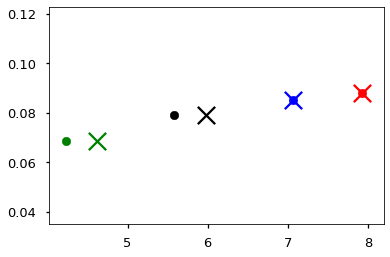

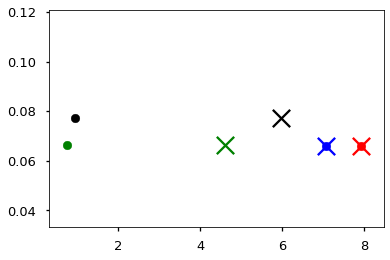

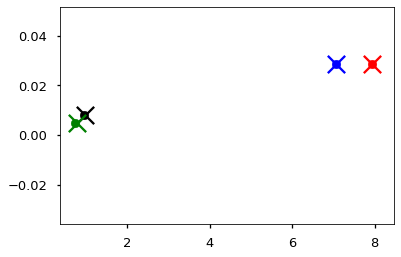

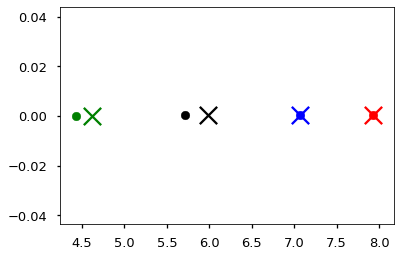

In [22]:
plot_standard_params(standard_df, 'hsic', 'line')
plot_standard_params(standard_df, 'hsic', 'sine')
plot_standard_params(standard_df, 'hsic', 'circle')
plot_standard_params(standard_df, 'hsic', 'random')

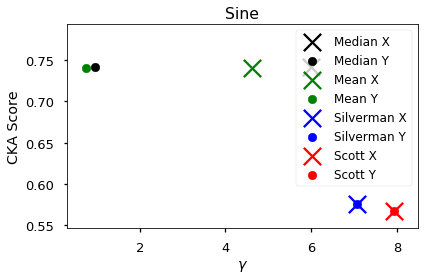

In [20]:
hsic_method = 'cka'
dataset = 'sine'


# ===============
# Line Plot
# ================
# fig, ax = plot_gamma_grid(grid_df, hsic_method, dataset)

# Plot points
fig, ax = plot_standard_params(standard_df, hsic_method, dataset)

ax.legend(ncol=1, fontsize=12)
ax.set_xlabel(r'$\gamma$')
ax.set_ylabel(f'{hsic_method.upper()} Score')
ax.set_title(f'{dataset.capitalize()}')
plt.tight_layout()
plt.show()


### Generate Gamma dist

In [35]:
init_gamma_X, X_gamma_grid

(5.98564438705438,
 array([13.15286095, 10.32183877,  8.10016589,  6.35668594,  4.98847267,
         3.91475367,  3.07214197,  2.41089404,  1.89197314,  1.48474478,
         1.16516827,  0.91437742,  0.7175668 ,  0.5631177 ,  0.44191223,
         0.34679503,  0.27215085,  0.2135731 ,  0.16760362,  0.13152861]))

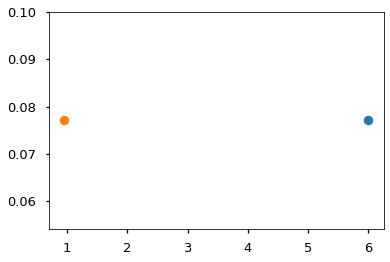

In [61]:
DataParams.dataset = 'sine'
X, Y = generate_data(DataParams)

init_gamma_X, init_gamma_Y = get_init_gammas(X, Y, method='median', factor=2)
ModelParams.gamma_X = init_gamma_X
ModelParams.gamma_Y = init_gamma_Y
base_score = get_hsic_score(ModelParams, X, Y, 'hsic')
plt.scatter(init_gamma_X, base_score)
plt.scatter(init_gamma_Y, base_score)

In [ ]:
s = np.array(scores)

In [89]:
n_grid_points = 20
gamma_grid = np.logspace(-2, 2, n_grid_points)

score_coords = pd.DataFrame()

for igamma_X in gamma_grid:
    for igamma_Y in gamma_grid:

        # calculate hsic
        ModelParams.gamma_X = igamma_X
        ModelParams.gamma_Y = igamma_Y
        score = get_hsic_score(ModelParams, X, Y, 'cka')
        
        score_coords = score_coords.append({'x': igamma_X, 'y': igamma_Y, 'score': score}, ignore_index=True)

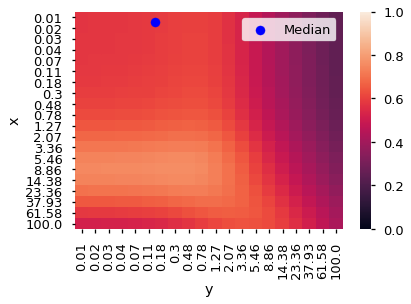

In [91]:
from matplotlib.ticker import FormatStrFormatter

# create a heatmap
heatmap_data = pd.pivot_table(score_coords, values='score', index=['x'], columns='y')

# heatmap_data.columns = np.sqrt(1 / 2 * heatmap_data.columns.values)
# heatmap_data.index = np.sqrt(1 / 2 * heatmap_data.index.values)
fig, ax = plt.subplots()
pts = sns.heatmap(
    data=heatmap_data,
    xticklabels=heatmap_data.columns.values.round(decimals=2),
    yticklabels=heatmap_data.index.values.round(decimals=2),
    vmin=0, vmax=1.0, ax=ax
)

ax.scatter(init_gamma_X, init_gamma_Y, color='blue', label='Median')
ax.legend()
plt.show()

# majorFormatter = FormatStrFormatter('%0.2f')
# pts.xaxis.set_major_formatter(majorFormatter)
# pts.yaxis.set_major_formatter(majorFormatter)

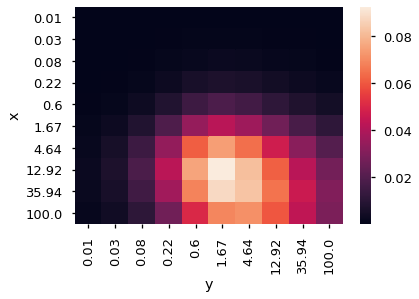

In [70]:
heatmap_data = pd.pivot_table(score_coords, values='score', index=['x'], columns='y')
# pivot_coord.head()


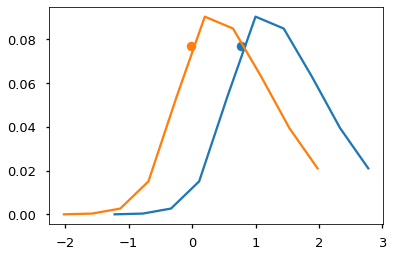

In [59]:
plt.plot(np.log10(X_gamma_grid), scores)
plt.plot(np.log10(Y_gamma_grid), scores)
plt.scatter(np.log10(init_gamma_X), base_score)
plt.scatter(np.log10(init_gamma_Y), base_score)

In [34]:
DataParams.dataset = 'sine'
X, Y = generate_data(DataParams)
init_gamma_X, init_gamma_Y = get_init_gammas(X, Y, method='median', factor=2)

X_gamma_grid = get_gamma_grid(init_gamma_X)
Y_gamma_grid = get_gamma_grid(init_gamma_Y)

assert init_gamma_X == np.any(X_gamma_grid)

AssertionError: 

0.1315286095278879 13.152860952788785


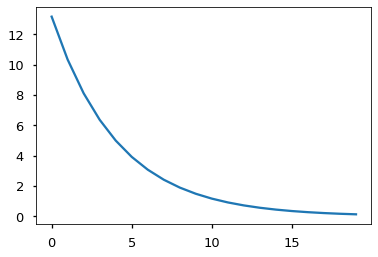

In [31]:
print(X_gamma_grid.min(), X_gamma_grid.max())
plt.plot(X_gamma_grid)

In [94]:
from tqdm import tqdm
from typing import Dict

def get_hsic_grid(params: Dict, init_method: str='median', hsic_method: str='hsic'):
    
    results = pd.DataFrame()
    
    # Extract Data
    for idataset in tqdm(params['exp'].datasets):
        params['data'].dataset = idataset
        X, Y = generate_data(params['data'])
    
        # get initial Gamma value
        init_gamma_X, init_gamma_Y = get_init_gammas(X, Y, method='median', factor=2)

        # get grids
        gamma_grid = np.logspace(-2, 2, n_grid_points)


        # loop through gammas
        for igamma_X in gamma_grid:
            for igamma_Y in gamma_grid:

                # calculate hsic
                params['model'].gamma_X = igamma_X
                params['model'].gamma_Y = igamma_Y
                score = get_hsic_score(params['model'], X, Y, hsic_method)

                # append and save results
                results = results.append({
                    'hsic_method': hsic_method, 
                    "dataset": idataset,
                    "gamma_X": igamma_X,
                    "gamma_Y": igamma_Y,
                    "score": score,
                }, ignore_index=True)
        
    return results

In [95]:
params = {
    'data': DataParams,
    'model': ModelParams,
    'exp': ExperimentParams
    
}

res_hsic_df = get_hsic_grid(params, 'median', 'hsic')
res_ka_df = get_hsic_grid(params, 'median', 'ka')
res_cka_df = get_hsic_grid(params, 'median', 'cka')

grid_df = pd.concat([res_hsic_df, res_ka_df, res_cka_df])

grid_df.head()

100%|██████████| 4/4 [02:28<00:00, 37.03s/it]


,dataset,gamma_X,gamma_Y,hsic_method,score
0,sine,0.01,0.010000,hsic,0.000009
1,sine,0.01,0.016238,hsic,0.000015
2,sine,0.01,0.026367,hsic,0.000024
3,sine,0.01,0.042813,hsic,0.000038
4,sine,0.01,0.069519,hsic,0.000060


In [135]:
grid_df = pd.concat([res_hsic_df, res_ka_df, res_cka_df])


### Visualization

#### Gamma Parameter Grid

In [197]:
from typing import Optional

def plot_gamma_grid(grid_df: pd.DataFrame, method: str, dataset: str, ax: Optional=None):
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,6.5))
    
    # ===========================================
    # Plot Gridded DataFrame
    # ===========================================
    
    # subset dataset
    grid_df_ = grid_df[grid_df['dataset'] == dataset].drop('dataset', axis=1)

    # subset hsic method
    grid_df_ = grid_df_[grid_df_['hsic_method'] == method].drop('hsic_method', axis=1)
    
    # create a heatmap
    grid_df_ = pd.pivot_table(grid_df_, values='score', index=['gamma_Y'], columns='gamma_X')
    
    # min max
    if method == 'hsic':
        vmax = 0.11
    else:
        vmax = 1.0

    # heatmap_data.columns = np.sqrt(1 / 2 * heatmap_data.columns.values)
    # heatmap_data.index = np.sqrt(1 / 2 * heatmap_data.index.values)
    pts = sns.heatmap(
        data=grid_df_,
        xticklabels=grid_df_.columns.values.round(decimals=2),
        yticklabels=grid_df_.index.values.round(decimals=2),
        vmin=0, vmax=vmax, ax=ax
    )
    

    return plt.gcf(), ax


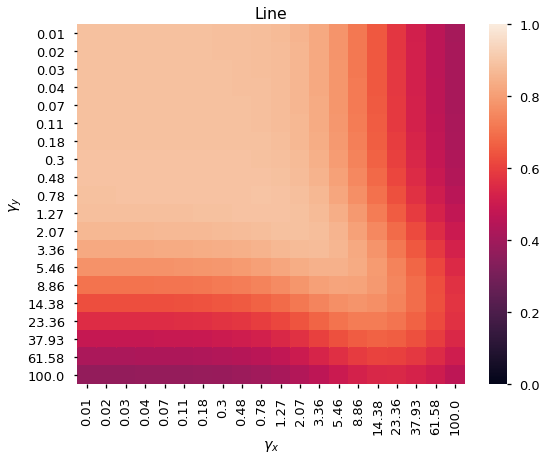

In [198]:
hsic_method = 'cka'
dataset = 'line'


# ===============
# Line Plot
# ================
fig, ax = plot_gamma_grid(grid_df, hsic_method, dataset)

# ax.legend()
ax.set_xlabel(r'$\gamma_x$')
ax.set_ylabel(r'$\gamma_y$')
ax.set_title(f'{dataset.capitalize()}')
plt.tight_layout()
plt.show()


#### Standard HSIC Parameter

In [203]:
def plot_standard_params(ax, params_df: pd.DataFrame, method: str, dataset: str):
    
    
    # subset dataset
    params_df = params_df[params_df['dataset'] == dataset]
    
    # subset hsic method
    params_df = params_df[params_df['hsic_method'] == method]
    
    # plot X
    estimators = [
        ('median', 'yellow'),
        ('mean', 'green'),
        ('silverman', 'blue'),
        ('scott', 'red'),
    ]
    
    
    for iest, icolor in estimators:
        
        # Plot X
        ax.scatter(
            params_df[params_df['gamma_est'] == iest].gamma_X, 
            params_df[params_df['gamma_est'] == iest].gamma_Y,
            s=500, c=icolor, label=f"{iest.capitalize()}", zorder=3, marker='.')
#         # Plot Y
#         ax.scatter(
#             params_df[params_df['gamma_est'] == iest].gamma_Y, 
#             params_df[params_df['gamma_est'] == iest].score,
#             s=300, c=icolor, label=f"{iest.capitalize()} Y", zorder=3, marker='.')
    
    
    return ax

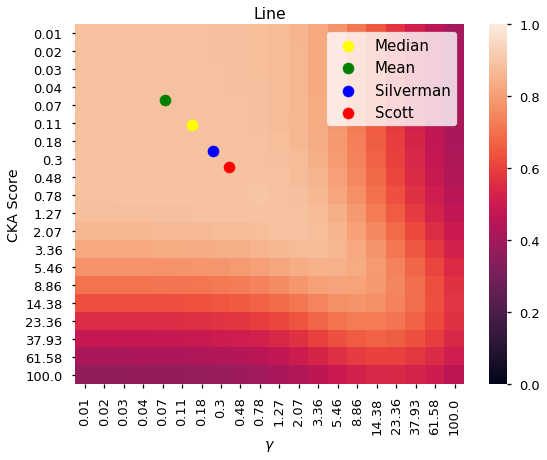

In [205]:
hsic_method = 'cka'
dataset = 'line'


# ===============
# Line Plot
# ================
fig, ax = plot_gamma_grid(grid_df, hsic_method, dataset)

# Plot points
ax = plot_standard_params(ax, standard_df, hsic_method, dataset)

ax.legend(ncol=1, fontsize=15)
ax.set_xlabel(r'$\gamma$')
ax.set_ylabel(f'{hsic_method.upper()} Score')
ax.set_title(f'{dataset.capitalize()}')
plt.tight_layout()
plt.show()

#### Everything Together

In [209]:
def plot_1d_init_figure(grid_df, param_df, hsic_method, dataset, ax: Optional=None):
    
    fig, ax = plot_gamma_grid(grid_df, hsic_method, dataset)

    # Plot points
    ax = plot_standard_params(ax, standard_df, hsic_method, dataset)

    ax.legend(ncol=1, fontsize=15)
    ax.set_xlabel(r'$\gamma_x$')
    ax.set_ylabel(r'$\gamma_y$')
#     ax.set_title(f"{dataset.capitalize()}")
#     plt.tight_layout()
#     plt.show()
    
    return None

#### Linear Data

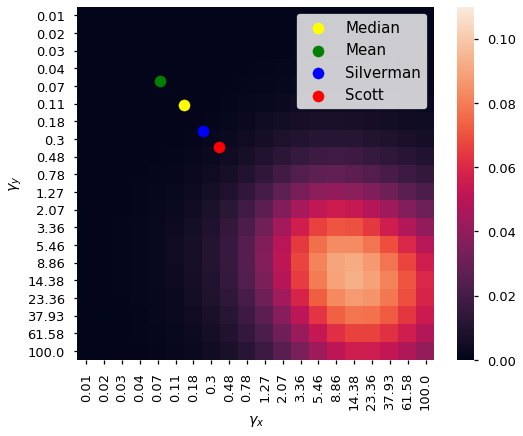

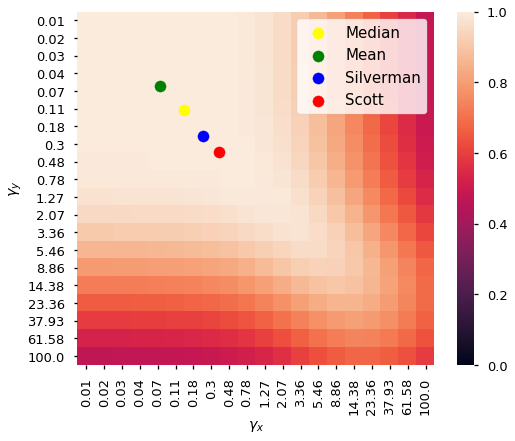

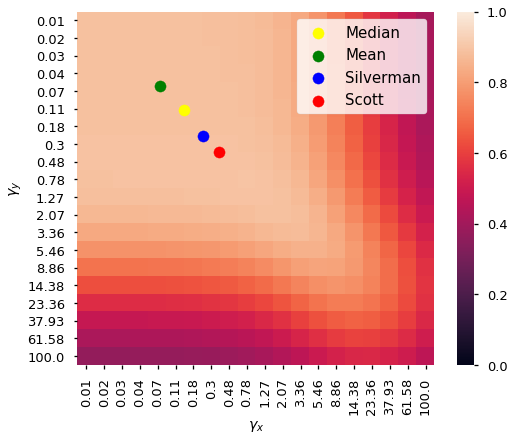

In [210]:
plot_1d_init_figure(grid_df, standard_df, 'hsic', 'line')
plot_1d_init_figure(grid_df, standard_df, 'ka', 'line')
plot_1d_init_figure(grid_df, standard_df, 'cka', 'line')

# plot_1d_init_figure(grid_df, standard_df, hsic_method, 'sine')
# plot_1d_init_figure(grid_df, standard_df, hsic_method, 'circle')
# plot_1d_init_figure(grid_df, standard_df, hsic_method, 'random')

#### Sine Data

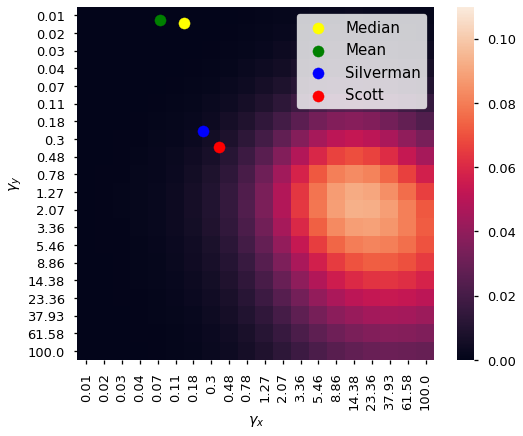

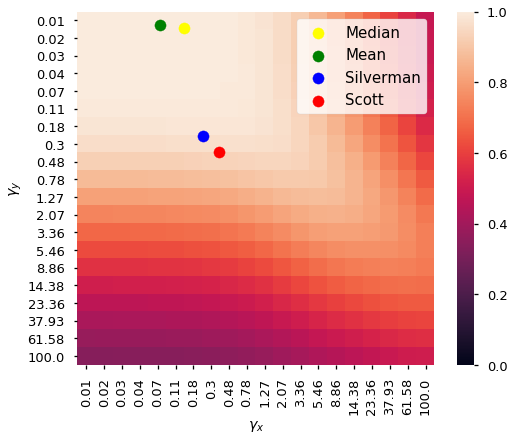

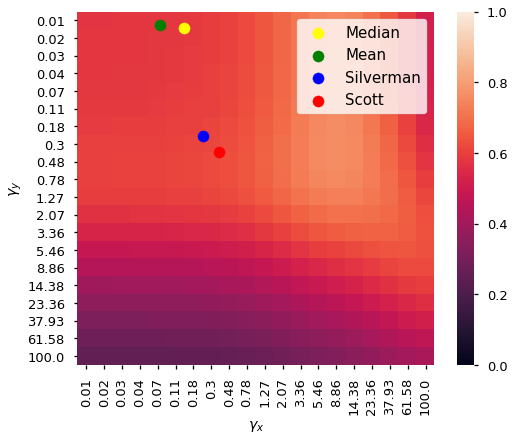

In [211]:
plot_1d_init_figure(grid_df, standard_df, 'hsic', 'sine')
plot_1d_init_figure(grid_df, standard_df, 'ka', 'sine')
plot_1d_init_figure(grid_df, standard_df, 'cka', 'sine')

#### Circle

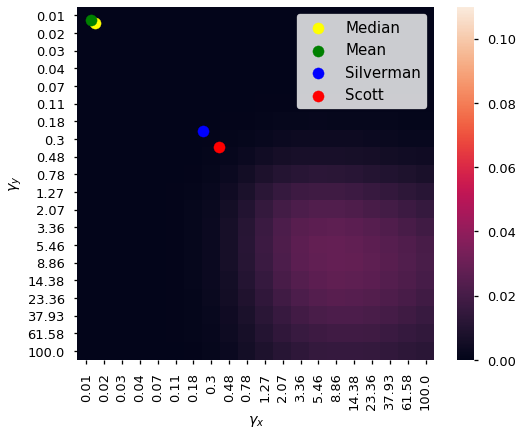

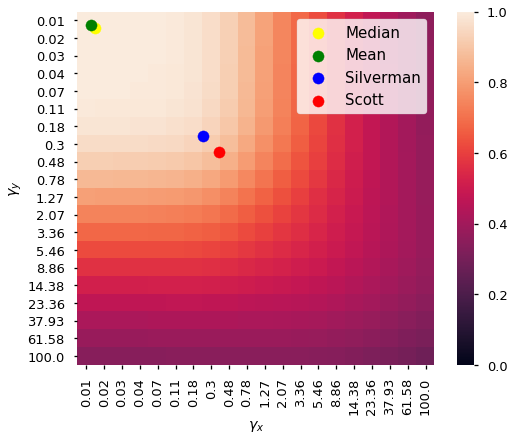

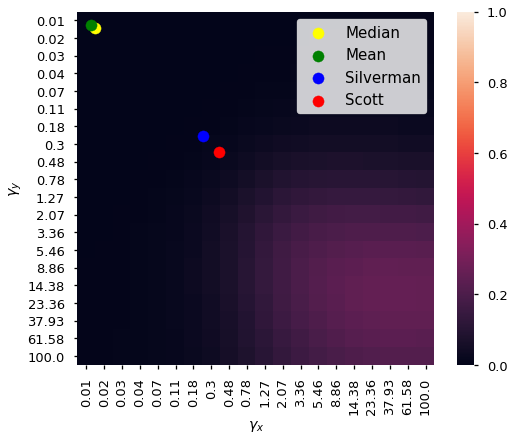

In [212]:
plot_1d_init_figure(grid_df, standard_df, 'hsic', 'circle')
plot_1d_init_figure(grid_df, standard_df, 'ka', 'circle')
plot_1d_init_figure(grid_df, standard_df, 'cka', 'circle')

#### Random

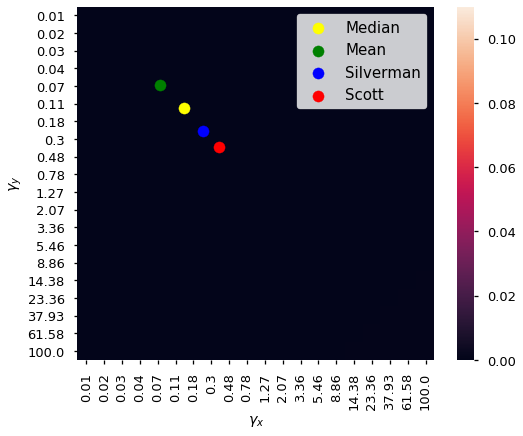

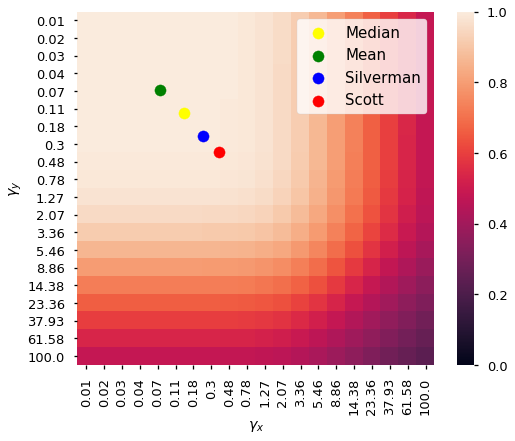

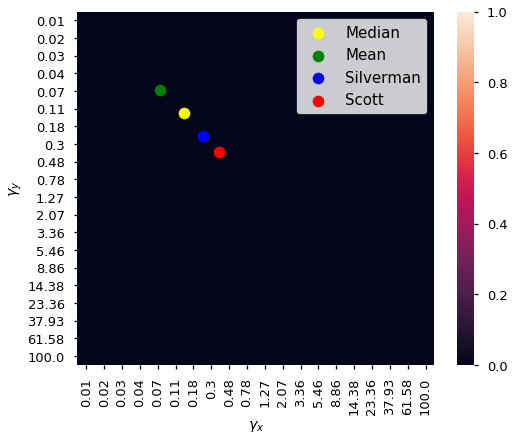

In [213]:
plot_1d_init_figure(grid_df, standard_df, 'hsic', 'random')
plot_1d_init_figure(grid_df, standard_df, 'ka', 'random')
plot_1d_init_figure(grid_df, standard_df, 'cka', 'random')

In [ ]:
X_gamma_grid = get_gamma_grid(init_gamma_X)
Y_gamma_grid = get_gamma_grid(init_gamma_Y)

In [67]:
def get_standard_gammas(X: np.ndarray, Y: np.ndarray):
    """Returns the standard gammas using initialization
    methods.
    * Silverman
    * Scott
    * Median
    * Mean
    
    """
    methods = [
        'silverman',
        'scott',
        'mean',
        'median',
    ]
    init_gammas = {}
    # get initial values
    for imethod in methods:
        init_gammas[imethod] = get_init_gammas(X, Y, method=imethod)
    return init_gammas

In [69]:
init_gammas = get_standard_gammas(X, Y)
print(init_gammas)

{'silverman': (7.063086251236918, 7.063086251236918), 'scott': (7.924465962305566, 7.924465962305566), 'mean': (4.614286870758685, 0.7424722533679164), 'median': (5.98564438705438, 0.9496243328834307)}


In [17]:
from typing import Optional

FIG_PATH = f'{cwd}/../../results/figures/init_gamma/'
def plot_max_hsic(results_list, scorer='hsic', function='line', sigma_est='mean', save=True, plot_legend=True):
    
    save_path = f'{cwd}/../../results/figures/init_gamma/'
    
    fig, ax = plt.subplots(nrows=1, figsize=(7, 5))
    
    # MAX HSIC Values
    max_idx = np.argmax(scorers[scorer])
    hsic_max = scorers[scorer][max_idx]
    gamma_max = gammas[max_idx]
    print(f'Max {scorer.upper()}: {hsic_max:.4f}')
    print(f'Max Gamma ({scorer.upper()}): {gamma_max:.4f}\n')

    # init HSIC Values
    init_median, _ = get_init(method='median', factor=1)
    median_hsic = HSIC(gamma_X=init_median, scorer=scorer).fit(X, Y).score(X)
#     print(init_median, median_hsic)
    
    init_mean, _ = get_init(method='mean', factor=1)
    mean_hsic = HSIC(gamma_X=init_mean, scorer=scorer).fit(X, Y).score(X)
#     print(init_mean, mean_hsic)
    
    init_silv, _ = get_init(method='silverman', factor=1)
    silv_hsic = HSIC(gamma_X=init_silv, scorer=scorer).fit(X, Y).score(X)
#     print(init_silv, silv_hsic)

    ax.set_xscale('log')
    ax.plot(gammas, scorers[scorer], color='red', linewidth=10, zorder=0)
    ax.scatter(gamma_max, hsic_max, s=300, c='yellow', label=f'Maximum', zorder=1)
    ax.scatter(init_median, median_hsic, s=300, c='black', label='Median', zorder=1)
    ax.scatter(init_mean, mean_hsic, s=300, c='green', label='Mean', zorder=1)
    ax.scatter(init_silv, silv_hsic, s=300, c='blue', label='Silverman', zorder=1)
    ax.set_xlabel('$\gamma$', fontsize=20)
    ax.set_ylabel(f'{scorer.upper()}', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    if scorer in ['ctka', 'tka']:
        ax.set_ylim([0.0, 1.1])
    elif scorer in ['hsic']:
        ax.set_ylim([0.0, 0.11])
    else:
        raise ValueError(f"Unrecognized scorer: {scorer}")
    if not plot_legend: 
        plt.legend(fontsize=20)
    plt.xticks(fontsize=20)
    
    plt.yticks(fontsize=20)
    plt.tight_layout()
    plt.show()
    
#     if save:
    save_name = f"demo_{function}_{sigma_est}_{scorer}"
    fig.savefig(save_path + save_name + ".png")

    # plot legend
    # colors = [c for c in handles.]
    handles, labels = ax.get_legend_handles_labels()
    if plot_legend:
        plot_legend_alone(handles, labels, save_name)


def plot_legend_alone(handles, labels, save_name: Optional[str] = None):
    fig_legend = plt.figure(constrained_layout=True)
    ax = fig_legend.add_subplot(111)
    fig_legend.legend(
        handles, labels, loc="upper center", frameon=False, ncol=len(labels)
    )
    # ax.axis("off")
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    fig_legend.canvas.draw()
    plt.tight_layout()
    # bbox_inches = "tight"
    # plt.tight_layout()

    if save_name is not None:
        fig_legend.savefig(FIG_PATH + save_name + "_legend.png", bbox_inches="tight")
    fig_legend.show()

In [50]:
class ExpParams:
    sigma_est = 

In [19]:
init_gamma, gammas = get_init_gammas(sigma_est, factor=factor, percent=0.5, n_gammas=n_gammas)

NameError: name 'sigma_est' is not defined

In [69]:
init_gamma

7.451958123570317

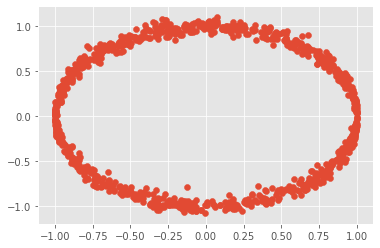

In [82]:
# Generate data
dataset = 'circle'
num_points = 1_000
noise_x = 0.05
noise_y = 0.05
seed = 1


X, Y = generate_dependence_data(
    dataset=dataset, 
    num_points=num_points,
    noise_x=noise_x,
    noise_y=noise_y,
    seed=seed
)

plt.scatter(X,Y)

In [84]:
# hsic model params
kernel = 'rbf'
subsample = None
bias = True
scorer = 'hsic'
sigma_est = 'max'

init_gamma, gammas = get_init(sigma_est, factor=factor, percent=None, n_gammas=n_gammas)
print(init_gamma)

clf_hsic = HSIC(
    kernel=kernel, 
    scorer=scorer,
    gamma_X=igamma,
    subsample=subsample,
    bias=bias
)

# calculate HSIC return scorer
clf_hsic.fit(X, Y);
print(clf_hsic.score(X))

ValueError: Unrecognized mode "max".

### Experiment Step

In [51]:
def get_init(X, Y, method='median', factor=1, percent=None, scale=1.0, n_gammas=100):
    
    # estimate sigma params
    factor = 1
    n_gammas = 100

    # Estimate Sigma
    sigma_x = estimate_sigma(X, method=method, percent=percent, scale=scale)
    sigma_y = estimate_sigma(Y, method=method, percent=percent, scale=scale)

    # init overall sigma is mean between two
    init_sigma = np.mean([sigma_x, sigma_y])

    # get sigma parameter grid
    sigmas = get_param_grid(init_sigma, factor, n_gammas)


    gammas = sigma_to_gamma(sigmas)
    init_gamma = sigma_to_gamma(init_sigma)
    return init_gamma, gammas

In [87]:
def experiment_step(X, Y, step_params: dict, exp_params: dict, ):
    
    # Get HSIC Score
    clf_hsic = HSIC(
        kernel=step_params.kernel, 
        center=step_params.center,
        gamma_X=step_params.X_gamma,
        gamma_Y=step_params.Y_gamma,
        subsample=exp_params.subsample,
        bias=exp_params.bias
    )

    # calculate HSIC return scorer
    clf_hsic.fit(X, Y);

    # hsic value and kernel alignment score
    corr_score = clf_hsic.score(X, normalize=step_params.normalize)

    results_df = pd.DataFrame({
        'score': corr_score,
        'kernel': step_params.kernel,
        'dataset': step_params.dataset,
        'gamma_x': step_params.X_gamma,
        'gamma_y': step_params.Y_gamma,
        'center': step_params.center,
        'normalize': step_params.normalize,
        'trial': step_params.seed
    }, index=[0])
    return results_df

In [250]:
@dataclass
class ExperimentParams:
    # ====================
    # Dataset Params
    # ====================
    datasets = ['sine', 'line', 'circle', 'random']
    num_points = 1_000
    noise_x = 0.025
    noise_y = 0.025
    
    # ====================
    # Experiment Params
    # ====================
    seeds = np.linspace(1, 10, 10, dtype=int)
    sigma_est = 'median'
    factor = 1
    n_gammas = 10
    percent = 0.5
    
    # ====================
    # Model Params
    # ====================
    kernels = ['rbf', 'linear']
    subsample = None
    bias = True
    normalize = [True, False]
    center = [True, False]
    save_name = 'test'

@dataclass
class StepParams:
    dataset = 'circle'
    kernel = 'rbf'
    center = True
    X_gamma = 1.0
    Y_gamma = 1.0
    normalize = True
    seed = 1
    init_gamma = 'median'
    
results_df = experiment_step(X, Y, StepParams, ExperimentParams)
results_df

,score,kernel,dataset,gamma_x,gamma_y,center,normalize,trial
0,0.65111,rbf,circle,1.0,1.0,True,True,1
